# How do AGNs selected with different techniques compare? 

By the IPAC Science Platform Team, last edit: Sep 25th, 2024

Active Galactic Nuclei (AGNs), some of the most powerful sources in the universe, emit a broad range of electromagnetic radiation, from radio waves to gamma rays. Consequently, there is a wide variety of AGN labels depending on the identification/selection scheme and the presence or absence of certain emissions (e.g., Radio loud/quiet, Quasars, Blazars, Seiferts, Changing looks). According to the unified model, this zoo of labels we see depend on a limited number of parameters, namely the viewing angle, the accretion rate, presence or lack of jets, and perhaps the properties of the host/environment (e.g., [Padovani et al. 2017](https://arxiv.org/pdf/1707.07134.pdf)). Here, we collect archival temporal data and labels from the literature to compare how some of these different labels/selection schemes compare. 

We use manifold learning and dimensionality reduction to learn the distribution of AGN lightcurves observed with different facilities. We mostly focus on UMAP ([Uniform Manifold Approximation and Projection, McInnes 2020](https://arxiv.org/pdf/1802.03426.pdf)) but also show two SOM ([Self organizing Map, Kohonen 1990](https://ieeexplore.ieee.org/document/58325)) examples. The reduced 2D projections from these two unsupervised ML techniques reveal similarities and overlaps of different selection techniques and coloring the projections with various statistical physical properties (e.g., mean brightness, fractional lightcurve variation) is informative of correlations of the selections technique with physics such as AGN variability. Using different parts of the EM in training (or in building the initial higher dimensional manifold) demonstrates how much information if any is in that part of the data for each labeling scheme, for example whether with ZTF optical light curves alone, we can identify sources with variability in WISE near IR bands. These techniques also have a potential for identifying targets of a specific class or characteristic for future follow up observations.

In [6]:
#!pip install -r requirements.txt
import sys
import os
import re
import time
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import pandas as pd
sys.path.append('code_src/')
from data_structures import MultiIndexDFObject
from ML_utils import unify_lc, stat_bands, autopct_format, combine_bands,\
mean_fractional_variation, normalize_mean_objects, normalize_max_objects, \
normalize_clipmax_objects, shuffle_datalabel, dtw_distance, stretch_small_values_arctan
from sample_lc import build_sample
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
try:
    import umap
    import umap.plot
except:
    !pip install umap-learn[plot]

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')
colors = [
    "#6C907D",  # Soft Green
    "#B9C3C2",  # Pale Gray
    "#8C9EFF",  # Periwinkle Blue
    "#FF6347",  # Tomato Red
    "#66CDAA",  # Medium Aquamarine
    "#E6E6FA",  # Lavender
    "#FAFAD2",  # Light Goldenrod Yellow
    "#FFD700",  # Gold
]

# To build a sample and generate the multiindex lc dataframe the code below is used, which takes long:
#!python sample_lc.py
#c,l = build_sample() # if coordinates and labels of the sample are needed separately

Here we load a parquet file of light curves generated using the multiband_lc notebook. One can build the sample from different sources in the literature and grab the data from archives of interes.

In [2]:
parquet_loadname = 'output/df_lc_5k.parquet.gzip'
parallel_df_lc = MultiIndexDFObject()
parallel_df_lc.data = pd.read_parquet(parquet_loadname)

## What is in this sample?

To effectively undertake machine learning (ML) in addressing a specific question, it's imperative to have a clear understanding of the data we'll be utilizing. This understanding aids in selecting the appropriate ML approach and, critically, allows for informed and necessary data preprocessing. For example whether a normalization is needed, and what band to choose for normalization. 

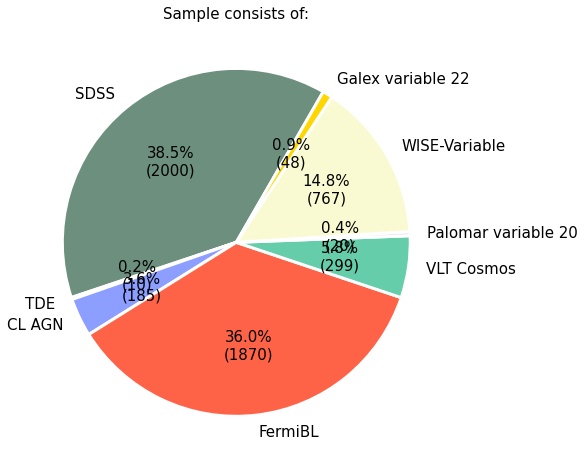

In [3]:
from collections import Counter
objid = parallel_df_lc.data.index.get_level_values('objectid')[:].unique()
seen = Counter()

# Grouping all changing look AGNs from the literature into one class:
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for b in objid:
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    if label in cl_labels:
        label = ['CL AGN']
    if label=='ZTF-Objname':
        label= ['TDE']
    if label=='Cicco19':
        label= ['VLT Cosmos']                
    seen.update(label)

#changing order of labels in dictionary only for text to be readable on the plot
from collections import OrderedDict
key_order = ('SDSS','TDE','CL AGN', 'FermiBL', 'VLT Cosmos','Palomar variable 20','WISE-Variable', 'Galex variable 22')
new_queue = OrderedDict()
for k in key_order:
    new_queue[k] = seen[k]
    
plt.figure(figsize=(8,8))
plt.title(r'Sample consists of:',size=15)
h = plt.pie(new_queue.values(),labels=new_queue.keys(),autopct=autopct_format(new_queue.values()), textprops={'fontsize': 15},startangle=60,  labeldistance=1.1, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors=colors)


In this particular example, the largest three subsamples are AGNs selected from [gamma ray observations by the Fermi Large Area Telescope](https://ui.adsabs.harvard.edu/abs/2015yCat..18100014A/similar) (with more than 98% blazars), AGNs from the optical spectra by the [SDSS quasar sample DR16Q](https://www.sdss4.org/dr17/algorithms/qso_catalog/) with a criteria on redshift (z<2), and a subset of AGNs selected in MIR WISE bands based on their variability ([csv in data folder credit RChary](https://ui.adsabs.harvard.edu/abs/2019AAS...23333004P/abstract)). We also include some smaller samples from the literature to see where they sit compared to the rest of the population and if they are localized on the 2D projection. These include the Changing Look AGNs from the literature (e.g., [LaMassa et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...800..144L/abstract), [Lyu et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...927..227L/abstract), [Hon et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.511...54H/abstract)), a sample which showed variability in Galex UV images ([Wasleske et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...933...37W/abstract)), a sample of variable sources identified in optical Palomar observarions ([Baldassare et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...896...10B/abstract)), and the optically variable AGNs in the COSMOS field from a three year program on VLT([De Cicco et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..33D/abstract)). We also include 30 Tidal Disruption Event coordinates identified from ZTF light curves [Hammerstein et al. 2023](https://iopscience.iop.org/article/10.3847/1538-4357/aca283/meta).

Text(0, 0.5, '#')

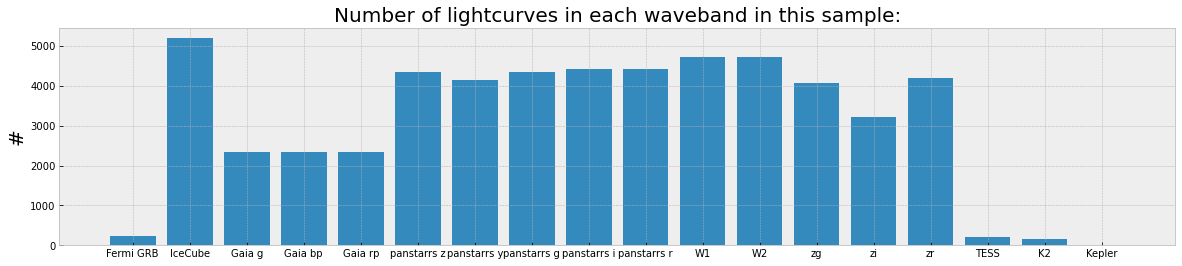

In [4]:
seen = Counter()
for b in objid:
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    bands = singleobj.loc[label[0],:,:].index.get_level_values('band')[:].unique()
    seen.update(bands)

plt.figure(figsize=(20,4))
plt.title(r'Number of lightcurves in each waveband in this sample:',size=20)
h = plt.bar(seen.keys(), seen.values())
plt.ylabel(r'#',size=20)

The histogram shows the number of lightcurves which ended up in the multi-index data frame from each of the archive calls in different wavebands/filters. We note that the IceCube peak should be corrected as it also include non detections in the figure above.

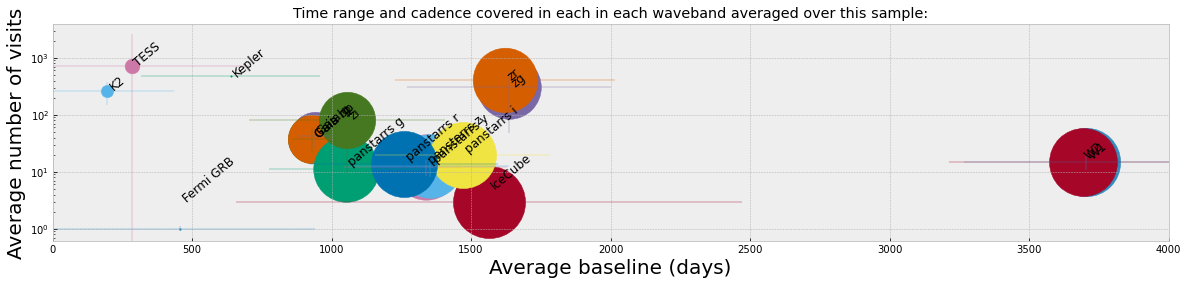

In [5]:
cadence = dict((el,[]) for el in seen.keys())
timerange = dict((el,[]) for el in seen.keys())

for b in objid:
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    bband = singleobj.index.unique('band')
    for bb in bband:
        bands = singleobj.loc[label[0],bb,:].index.get_level_values('time')[:]
        #bands.values
        #print(bb,len(bands[:]),np.round(bands[:].max()-bands[:].min(),1))    
        cadence[bb].append(len(bands[:]))
        if bands[:].max()-bands[:].min()>0:
            timerange[bb].append(np.round(bands[:].max()-bands[:].min(),1))    

plt.figure(figsize=(20,4))
plt.title(r'Time range and cadence covered in each in each waveband averaged over this sample:')
for el in cadence.keys():
    #print(el,len(cadence[el]),np.mean(cadence[el]),np.std(cadence[el]))
    #print(el,len(timerange[el]),np.mean(timerange[el]),np.std(timerange[el]))
    plt.scatter(np.mean(timerange[el]),np.mean(cadence[el]),label=el,s=len(timerange[el]))
    plt.errorbar(np.mean(timerange[el]),np.mean(cadence[el]),xerr=np.std(timerange[el]),yerr=np.std(cadence[el]),alpha=0.2)
    plt.annotate(el,(np.mean(timerange[el]),np.mean(cadence[el])+2),size=12, rotation=40)
plt.ylabel(r'Average number of visits',size=20) 
plt.xlabel(r'Average baseline (days)',size=20) 
plt.xlim([0,4000])
plt.yscale('log')

While from the histogram plot we see which bands have the highest number of observed lightcurves, what might matter more in finding/selecting variability or changing look in lightcurves is the cadence and the average baseline of observations. For instance, Panstarrs has a large number of lightcurve detections in our sample, but from the figure above we see that the average number of visits and the baseline for those observations are considerably less than ZTF. WISE also shows the longest baseline of observations which is suitable to finding longer term variability in objects.

## Looking at ZTF lightcurves alone

We first look at this sample only in ZTF bands which have the largest number of visits. We start by unifying the time grid of the light curves so oobjects with different start time or number of observations can be compared. We do this by interpolation to a new grid. The choice of the grid resolution and baseline is strictly dependent on the input data, in this case ZTF, to preserve as much as possible all the information from the observations. We measure basic statistics and combine the tree observed ZTF bands into one longer array as input to dimensionailty reduction after deciding on normalization. We also do a shuffling of the sample to be sure that the separations of different classes by ML are not simply due to the order they are seen in training (in case it is not done by the ML routine itself).

  0%|          | 0/5199 [00:00<?, ?it/s]

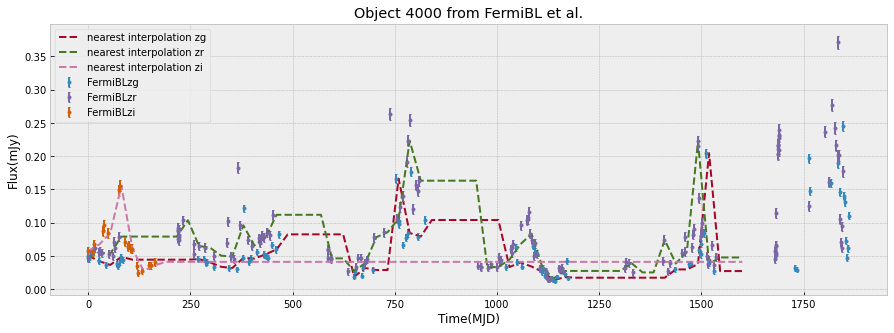

  0%|          | 4/5199 [00:00<05:57, 14.51it/s]

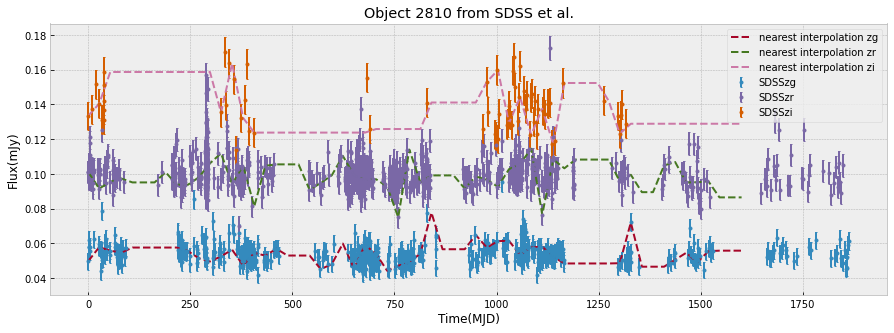

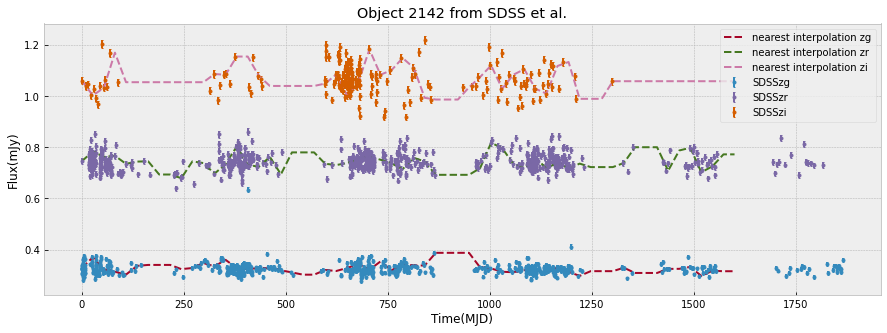

  0%|          | 6/5199 [00:00<15:02,  5.75it/s]

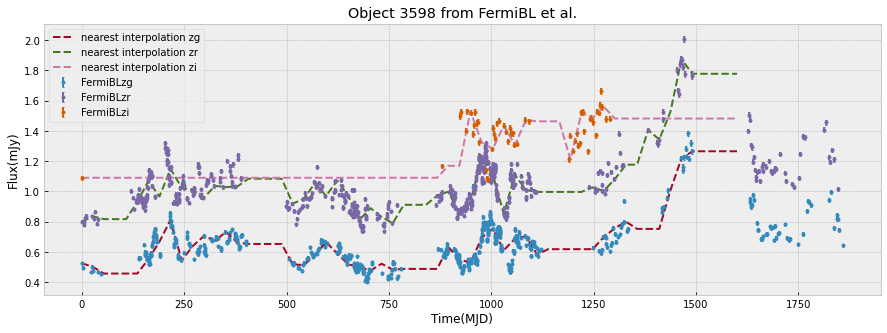

  1%|          | 41/5199 [00:01<01:39, 51.72it/s]

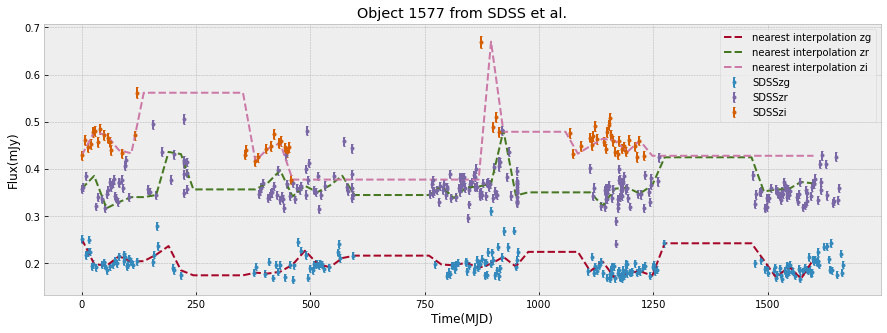

100%|██████████| 5199/5199 [00:42<00:00, 121.40it/s]


In [6]:
bands_inlc = ['zg','zr','zi']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=60,numplots=5)

# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)

# combine different waveband into one array
dat_notnormal = combine_bands(objects,bands_inlc)

# Normalize the combinde array by maximum of brightness in a waveband after clipping outliers:
dat = normalize_clipmax_objects(dat_notnormal,maxarray,band = 1)

# Normalize the combinde array by mean brightness in a waveband after clipping outliers:
datm = normalize_clipmax_objects(dat_notnormal,meanarray,band = 1)

# shuffle data incase the ML routines are sensitive to order
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

The combination of the tree bands into one longer arrays in order of increasing wavelength, can be seen as providing both the SED shape as well as variability in each from the light curve. Figure below demonstrates this as well as our normalization choice. We normalize the data in ZTF R band as it has a higher average numbe of visits compared to G and I band. We remove outliers before measuring the mean and max of the light curve and normalizing by it. This normalization can be skipped if one is mearly interested in comparing brightnesses of the data in this sample, but as dependence on flux is strong to look for variability and compare shapes of light curves a normalization helps.

Text(0, 0.5, 'Normalized Flux (mean r band)')

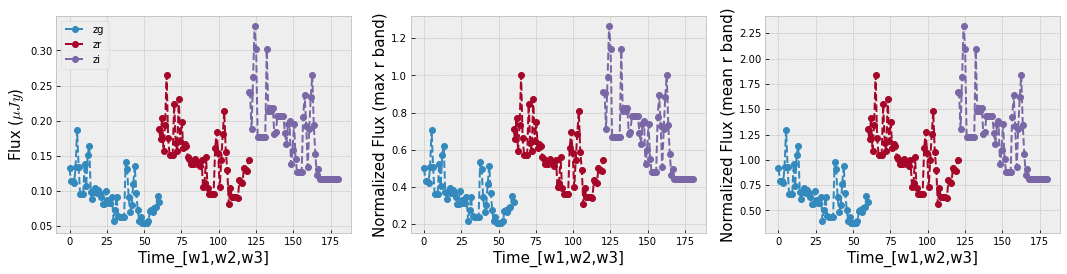

In [7]:
r = np.random.randint(np.shape(dat)[1])
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)

for i,l in enumerate(bands_inlc):
    s = int(np.shape(dat)[1]/len(bands_inlc))
    first = int(i*s)
    last = first+s
    plt.plot(np.linspace(first,last,s),dat_notnormal[r,first:last],'o',linestyle='--',label=l)
plt.xlabel(r'Time_[w1,w2,w3]',size=15)
plt.ylabel(r'Flux ($\mu Jy$)',size=15)
plt.legend(loc=2)

plt.subplot(1,3,2)
for i,l in enumerate(bands_inlc):
    s = int(np.shape(dat)[1]/len(bands_inlc))
    first = int(i*s)
    last = first+s
    plt.plot(np.linspace(first,last,s),dat[r,first:last],'o',linestyle='--',label=l)
plt.xlabel(r'Time_[w1,w2,w3]',size=15)
plt.ylabel(r'Normalized Flux (max r band)',size=15)

plt.subplot(1,3,3)
for i,l in enumerate(bands_inlc):
    s = int(np.shape(dat)[1]/len(bands_inlc))
    first = int(i*s)
    last = first+s
    plt.plot(np.linspace(first,last,s),datm[r,first:last],'o',linestyle='--',label=l)
plt.xlabel(r'Time_[w1,w2,w3]',size=15)
plt.ylabel(r'Normalized Flux (mean r band)',size=15)


Now we can train a UMAP with the processed data vectors above. Different choices for the number of neighbors, minimum distance and metric can be made and a parameter space can be explored. We show here our preferred combination given this data. We choose manhattan distance (also called [the L1 distance](https://en.wikipedia.org/wiki/Taxicab_geometry)) as it is optimal for the kind of grid we interpolated on, for instance we want the distance to not change if there are observations missing. Another metric appropriate for our purpose in time domain analysis is Dynamic Time Warping ([DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping)), which is insensitive to a shift in time. This is helpful as we interpolate the observations onto a grid starting from time 0 and when discussing variability we care less about when it happens and more about whether and how strong it happened. As the measurement of the DTW distance takes longer compared to the other metrics we show examples here with manhattan and only show one example exploring the parameter space including a DTW metric in the last cell of this notebook.

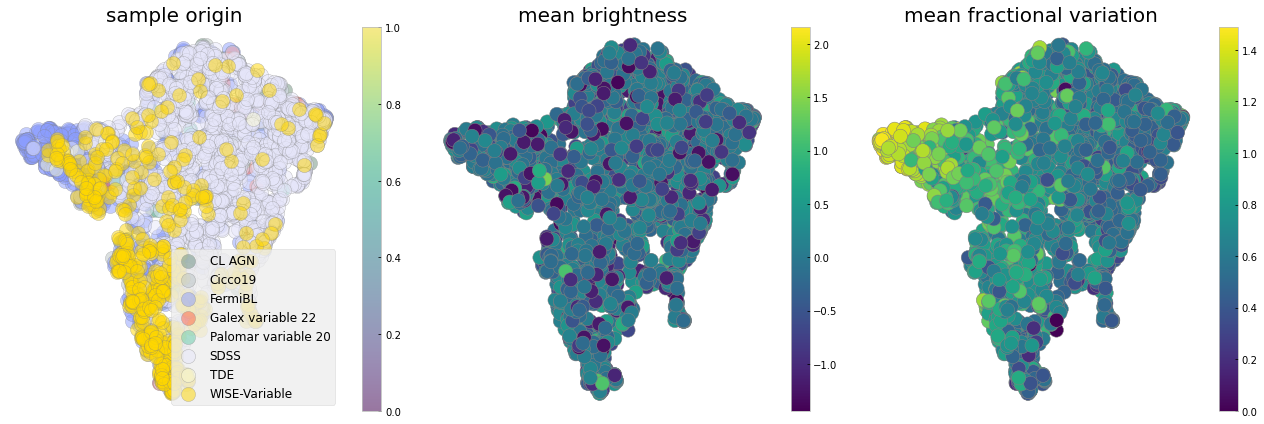

In [8]:
plt.figure(figsize=(18,6))
markersize=200
mapper = umap.UMAP(n_neighbors=10,min_dist=0.01,metric='manhattan',random_state=20).fit(data)

ax1 = plt.subplot(1,3,2)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=np.log10(np.nansum(meanarray,axis=0)),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(1,3,3)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.nansum(fvar_arr,axis=0),factor=3),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(1,3,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.5,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')

plt.tight_layout()

#plt.savefig('umap-ztf.png')

The left panel is colorcoded by the origin of the sample. The middle panel shows the sum of mean brightnesses in three bands (arbitrary unit) demonstrating that after normalization we see no correlation with brightness. The panel on the right is color coded by a statistical measure of variability (i.e. the fractional variation [see here](https://ned.ipac.caltech.edu/level5/Sept01/Peterson2/Peter2_1.html)). As with the plotting above it is not easy to see all the data points and correlations in the next two cells measure probability of belonging to each original sample as well as the mean statistical property on an interpolated grid on this reduced 2D projected surface.

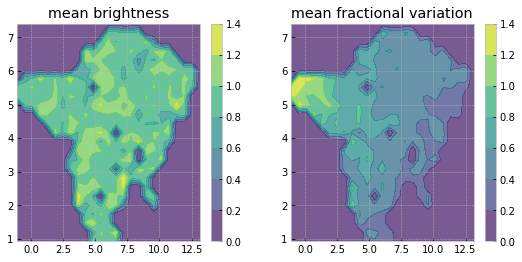

In [9]:
# Define a grid
grid_resolution = 25# Number of cells in the grid
x_min, x_max = mapper.embedding_[:, 0].min(), mapper.embedding_[:, 0].max()
y_min, y_max = mapper.embedding_[:, 1].min(), mapper.embedding_[:, 1].max()
x_grid = np.linspace(x_min, x_max, grid_resolution)
y_grid = np.linspace(y_min, y_max, grid_resolution)
x_centers, y_centers = np.meshgrid(x_grid, y_grid)

# Calculate mean property in each grid cell
mean_property1,mean_property2 = np.zeros_like(x_centers),np.zeros_like(x_centers)
propmean=stretch_small_values_arctan(np.nansum(meanarray,axis=0),factor=2)
propfvar=stretch_small_values_arctan(np.nansum(fvar_arr,axis=0),factor=2)
for i in range(grid_resolution - 1):
    for j in range(grid_resolution - 1):
        mask = (
            (mapper.embedding_[:, 0] >= x_grid[i]) &
            (mapper.embedding_[:, 0] < x_grid[i + 1]) &
            (mapper.embedding_[:, 1] >= y_grid[j]) &
            (mapper.embedding_[:, 1] < y_grid[j + 1])
        )
        if np.sum(mask) > 0:
            mean_property1[j, i] = np.mean(propmean[mask])
            mean_property2[j, i] = np.mean(propfvar[mask])
            
            
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title('mean brightness')
plt.contourf(x_centers, y_centers, mean_property1, cmap='viridis', alpha=0.7)
plt.colorbar()
#plt.axis('off')
plt.subplot(1,2,2)
plt.title('mean fractional variation')
plt.contourf(x_centers, y_centers, mean_property2, cmap='viridis', alpha=0.7)
plt.colorbar()
#plt.axis('off')


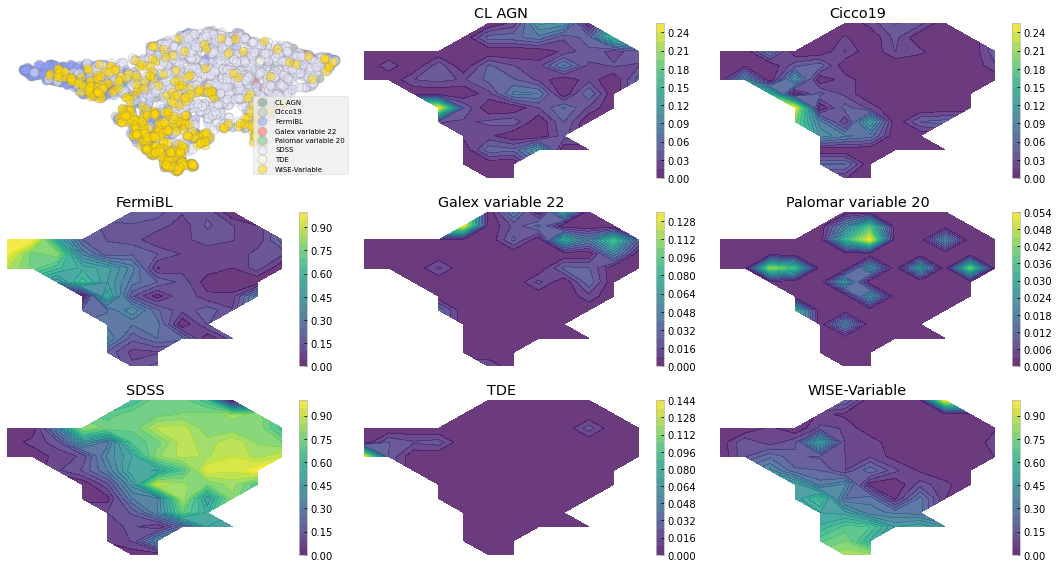

In [10]:
# Calculate 2D histogram
hist, x_edges, y_edges = np.histogram2d(mapper.embedding_[:, 0], mapper.embedding_[:, 1], bins=12)

# Calculate class probabilities for each bin
class_probabilities = []

for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    hist_per_cluster, _, _ = np.histogram2d(mapper.embedding_[u,0], mapper.embedding_[u,1], bins=(x_edges, y_edges))
    class_prob = hist_per_cluster / hist
    class_probabilities.append(class_prob)
    #print(lab, class_prob)

labs = np.unique(fzr)
plt.figure(figsize=(15,8))
ax0 = plt.subplot(3,3,1)
for i, prob in enumerate(class_probabilities):
    plt.subplot(3,3,i+2)
    plt.title(labs[i])
    plt.contourf(x_edges[:-1], y_edges[:-1], prob.T, levels=20, alpha=0.8)
    plt.colorbar()
    plt.axis('off')
    u=(fzr[:]==labs[i])
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=80,c=colors[i],alpha=0.5,edgecolor='gray',label=labs[i])
ax0.legend(loc=4,fontsize=7)
ax0.axis('off')
plt.tight_layout()


Figure above shows how with ZTF light curves alone we can separate some of these AGN samples, where they have overlaps. We can do a similar exercise with other dimensionality reduction techniques. Below we show two SOMs one with normalized and another with no normalization. The advantage of Umaps to SOMs is that in practice you may change the parameters to separate classes of vastly different data points, as distance is preserved on a umap. On a SOM however only topology of higher dimensions is preserved and not distance hence, the change on the 2d grid does not need to be smooth and from one cell to next there might be larg jumps. On the other hand, an advantage of the SOM is that by definition it has a grid and no need for a posterior interpolation (as we did above) is needed to map more data or to measure probabilities, etc.


In [11]:
from sompy import * #using the SOMPY package from https://github.com/sevamoo/SOMPY
msz0,msz1 = 12,12
sm = sompy.SOMFactory.build(data, mapsize=[msz0,msz1], mapshape='planar', lattice='rect', initialization='pca') 
sm.train(n_job=4, shared_memory = 'no')

 Training...
 pca_linear_initialization took: 0.026000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 2

 epoch: 1 ---> elapsed time:  0.051000, quantization error: 8.099897

 epoch: 2 ---> elapsed time:  0.035000, quantization error: 7.654040

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 2

 epoch: 1 ---> elapsed time:  0.036000, quantization error: 6.778190

 epoch: 2 ---> elapsed time:  0.045000, quantization error: 6.585511

 Final quantization error: 6.504251
 train took: 0.290000 seconds


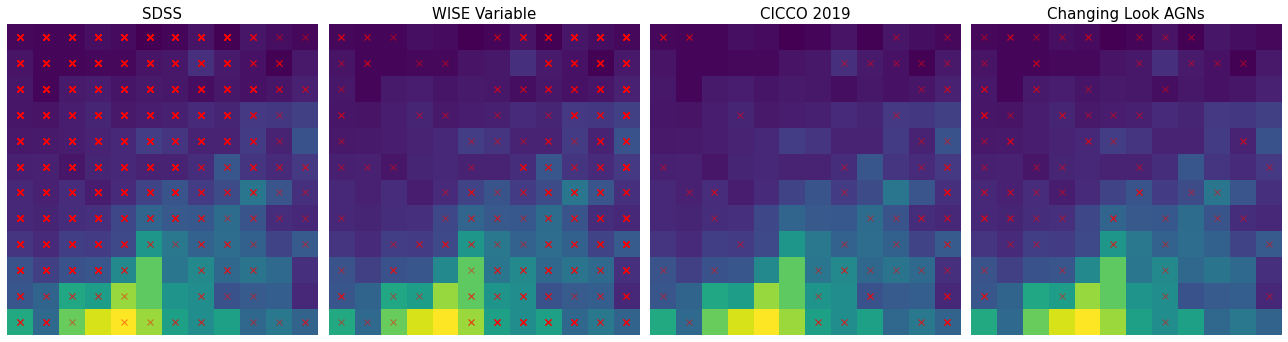

In [12]:
a=sm.bmu_ind_to_xy(sm.project_data(data))
x,y=np.zeros(len(a)),np.zeros(len(a))
k=0
for i in a:
    x[k]=i[0]
    y[k]=i[1]
    k+=1    
med_r=np.zeros([msz0,msz1])
fvar_new = stretch_small_values_arctan(np.nansum(fvar_arr,axis=0),factor=1)
for i in range(msz0):
    for j in range(msz1):
        unja=(x==i)&(y==j)
        med_r[i,j]=(np.nanmedian(fvar_new[unja]))
        

plt.figure(figsize=(18,8))
plt.subplot(1,4,1)
plt.title('SDSS',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')

d = []
for i,f in enumerate(fzr):
    if f=='SDSS':
        d.append(data[i,:])
dsdss =np.array(d)
asdss=sm.bmu_ind_to_xy(sm.project_data(dsdss))                   
x,y=np.zeros(len(asdss)),np.zeros(len(asdss))
k=0
for i in asdss:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,2)
plt.title('WISE Variable',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='WISE-Variable':
        d.append(data[i,:])
dwise =np.array(d)
awise=sm.bmu_ind_to_xy(sm.project_data(dwise))                   
x,y=np.zeros(len(awise)),np.zeros(len(awise))
k=0
for i in awise:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,3)
plt.title('CICCO 2019',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='Cicco19':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)


plt.subplot(1,4,4)
plt.title('Changing Look AGNs',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='CL AGN':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.tight_layout()

The above SOMs are colored by the mean fractional variation of the lightcurves in all bands (a measure of AGN variability). The crosses are different samples mapped to the trained SOM to see if they are distinguishable on a normalized lightcurve som.

In [13]:
# shuffle data incase the ML routines are sensitive to order
data,fzr,p = shuffle_datalabel(dat_notnormal,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'       
sm = sompy.SOMFactory.build(data, mapsize=[10,10], mapshape='planar', lattice='rect', initialization='pca') 
sm.train(n_job=4, shared_memory = 'no')

 Training...
 pca_linear_initialization took: 0.025000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 1

 epoch: 1 ---> elapsed time:  0.039000, quantization error: 15.883537

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 2

 epoch: 1 ---> elapsed time:  0.029000, quantization error: 1.764931

 epoch: 2 ---> elapsed time:  0.028000, quantization error: 1.342023

 Final quantization error: 1.212161
 train took: 0.215000 seconds


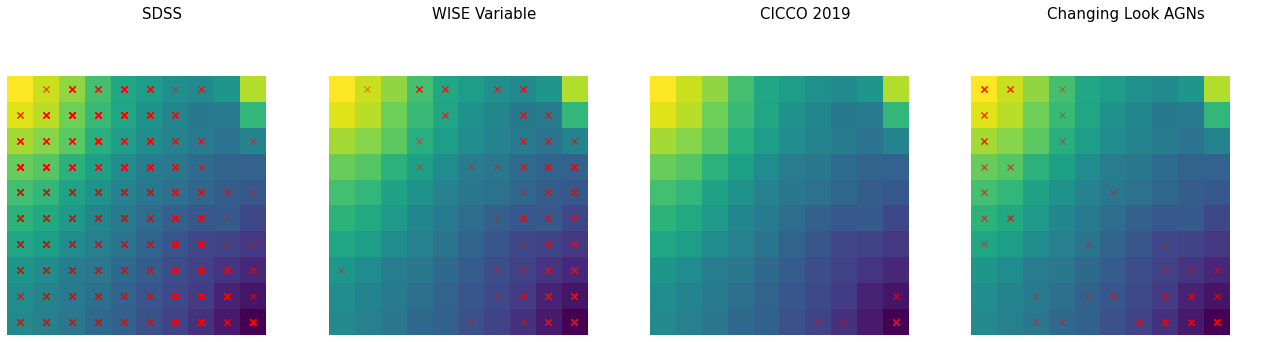

In [14]:
a=sm.bmu_ind_to_xy(sm.project_data(data))
x,y=np.zeros(len(a)),np.zeros(len(a))
k=0
for i in a:
    x[k]=i[0]
    y[k]=i[1]
    k+=1    
med_r=np.zeros([msz0,msz1])
fvar_new = stretch_small_values_arctan(np.nansum(maximum_arr,axis=0),factor=0.5)
for i in range(msz0):
    for j in range(msz1):
        unja=(x==i)&(y==j)
        med_r[i,j]=(np.nanmedian(fvar_new[unja]))
        

plt.figure(figsize=(18,8))
plt.subplot(1,4,1)
plt.title(r'SDSS',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')

d = []
for i,f in enumerate(fzr):
    if f=='SDSS':
        d.append(data[i,:])
dsdss =np.array(d)
asdss=sm.bmu_ind_to_xy(sm.project_data(dsdss))                   
x,y=np.zeros(len(asdss)),np.zeros(len(asdss))
k=0
for i in asdss:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,2)
plt.title(r'WISE Variable',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='WISE-Variable':
        d.append(data[i,:])
dwise =np.array(d)
awise=sm.bmu_ind_to_xy(sm.project_data(dwise))                   
x,y=np.zeros(len(awise)),np.zeros(len(awise))
k=0
for i in awise:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,3)
plt.title(r'CICCO 2019',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='Cicco19':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)


plt.subplot(1,4,4)
plt.title(r'Changing Look AGNs',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='CL AGN':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.tight_layout()

skipping the normalization of lightcurves, can show for example how the Cicco et al. 2019 sample, from the 3year VLT observations of the COSMOS field are all fainter compared to the rest.

# Repeating the above, this time with Panstarrs observations

  0%|          | 0/5199 [00:00<?, ?it/s]

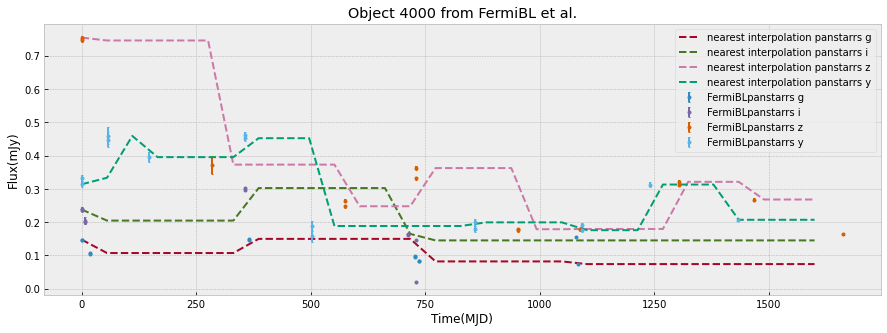

100%|██████████| 5199/5199 [00:51<00:00, 100.70it/s]


In [15]:
bands_inlc = ['panstarrs g','panstarrs r','panstarrs i','panstarrs z', 'panstarrs y']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=30)

# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)

# combine different waveband into one array
dat_notnormal = combine_bands(objects,bands_inlc)

# Normalize the combinde array by maximum of brightness in a waveband after clipping outliers:
dat = normalize_clipmax_objects(dat_notnormal,maxarray,band = 1)

# Normalize the combinde array by mean brightness in a waveband after clipping outliers:
datm = normalize_clipmax_objects(dat_notnormal,meanarray,band = 1)

# shuffle data incase the ML routines are sensitive to order
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

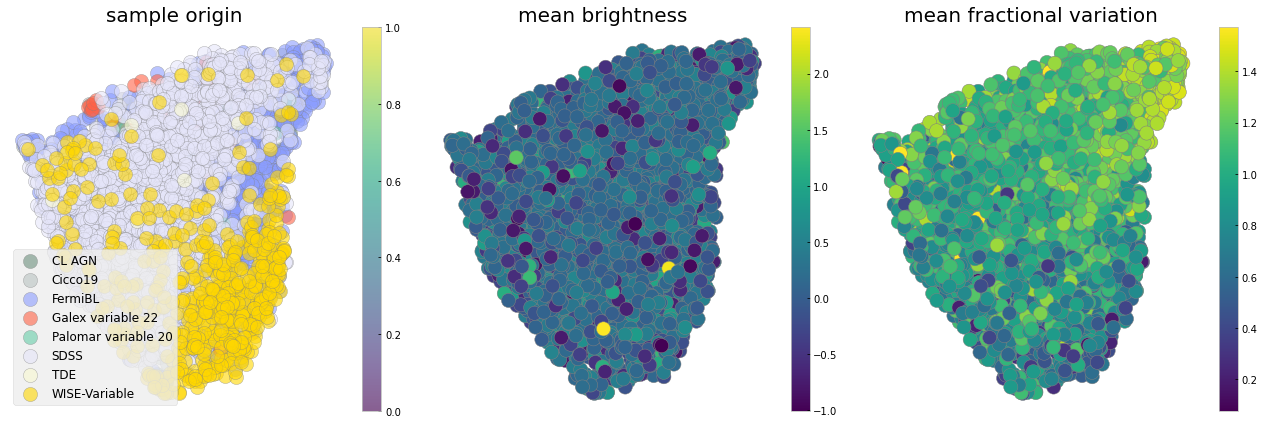

In [16]:
plt.figure(figsize=(18,6))
markersize=200
mapper = umap.UMAP(n_neighbors=50,min_dist=0.5,metric='manhattan',random_state=20).fit(data)

ax1 = plt.subplot(1,3,2)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=np.log10(np.nansum(meanarray,axis=0)),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(1,3,3)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.nansum(fvar_arr,axis=0),factor=2),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(1,3,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')

plt.tight_layout()
#plt.savefig('umap-Panstarrs.png')

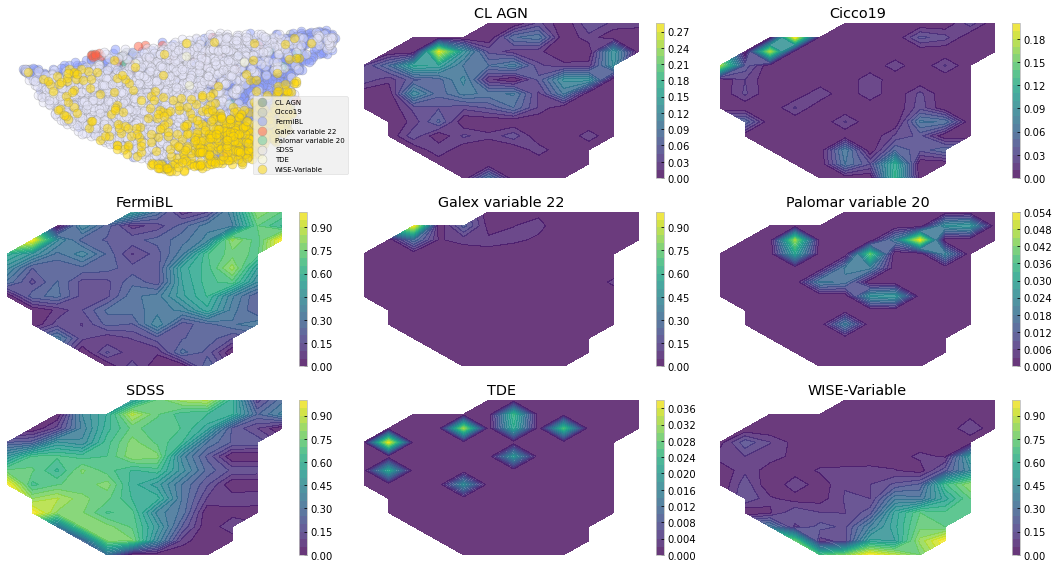

In [17]:
# Calculate 2D histogram
hist, x_edges, y_edges = np.histogram2d(mapper.embedding_[:, 0], mapper.embedding_[:, 1], bins=12)

# Calculate class probabilities for each bin
class_probabilities = []

for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    hist_per_cluster, _, _ = np.histogram2d(mapper.embedding_[u,0], mapper.embedding_[u,1], bins=(x_edges, y_edges))
    class_prob = hist_per_cluster / hist
    class_probabilities.append(class_prob)
    #print(lab, class_prob)

labs = np.unique(fzr)
plt.figure(figsize=(15,8))
ax0 = plt.subplot(3,3,1)
for i, prob in enumerate(class_probabilities):
    plt.subplot(3,3,i+2)
    plt.title(labs[i])
    plt.contourf(x_edges[:-1], y_edges[:-1], prob.T, levels=20, alpha=0.8)
    plt.colorbar()
    plt.axis('off')
    u=(fzr[:]==labs[i])
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=80,c=colors[i],alpha=0.5,edgecolor='gray',label=labs[i])
ax0.legend(loc=4,fontsize=7)
ax0.axis('off')
plt.tight_layout()

# ZTF + WISE

  0%|          | 0/5199 [00:00<?, ?it/s]

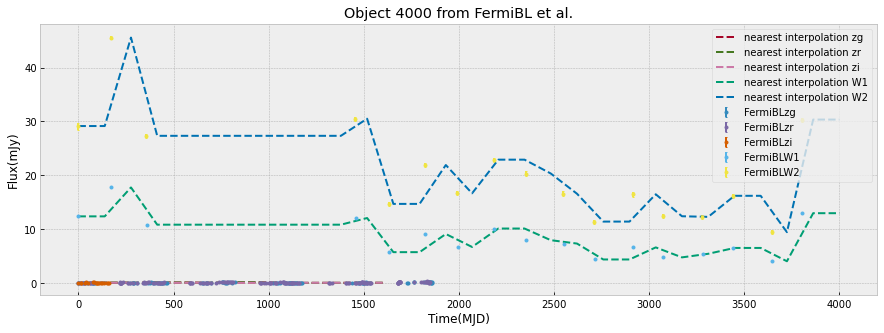

  0%|          | 4/5199 [00:00<07:26, 11.63it/s]

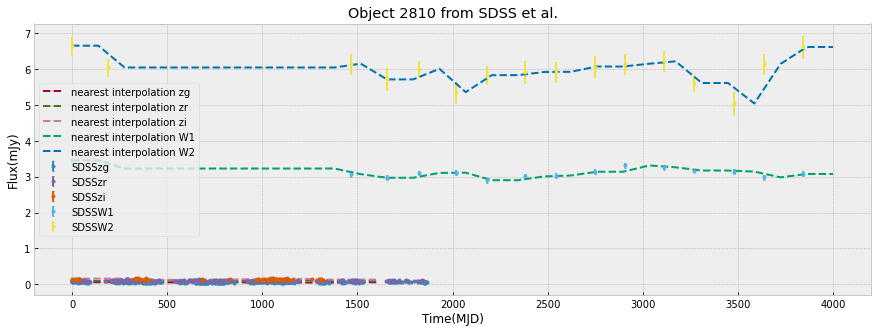

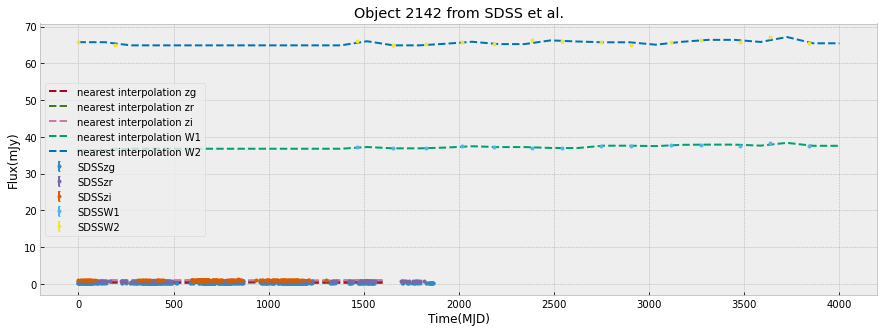

100%|██████████| 5199/5199 [00:48<00:00, 107.07it/s]


In [18]:
bands_inlc = ['zg','zr','zi','W1','W2']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=30,numplots=3)
# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)
dat_notnormal = combine_bands(objects,bands_inlc)
dat = normalize_clipmax_objects(dat_notnormal,maxarray,band = -1)
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

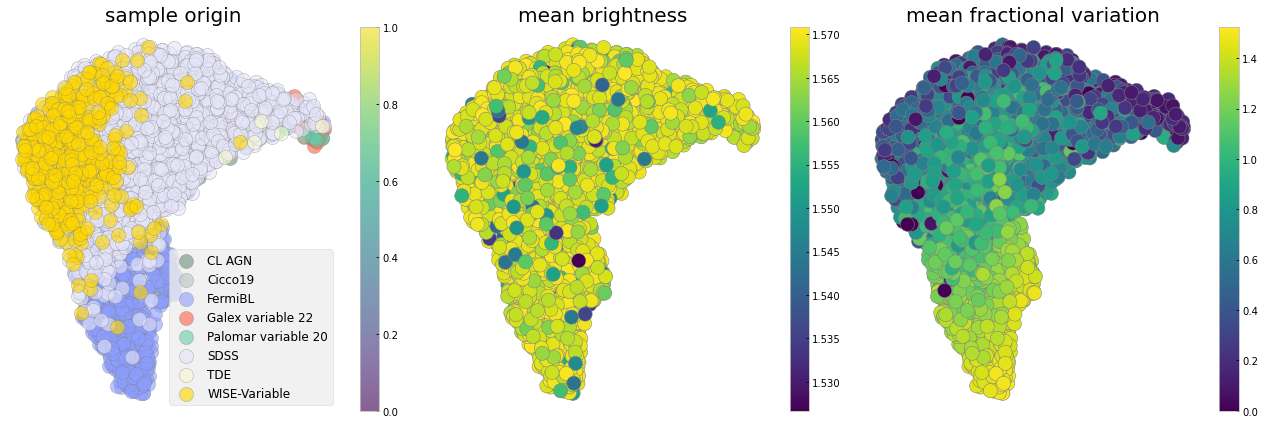

In [19]:
plt.figure(figsize=(18,6))
markersize=200
mapper = umap.UMAP(n_neighbors=200,min_dist=1,metric='manhattan',random_state=12).fit(data)

ax1 = plt.subplot(1,3,2)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.nansum(meanarray,axis=0),factor=10),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(1,3,3)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.nansum(fvar_arr[-2:-1,:],axis=0),factor=10),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(1,3,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')

plt.tight_layout()

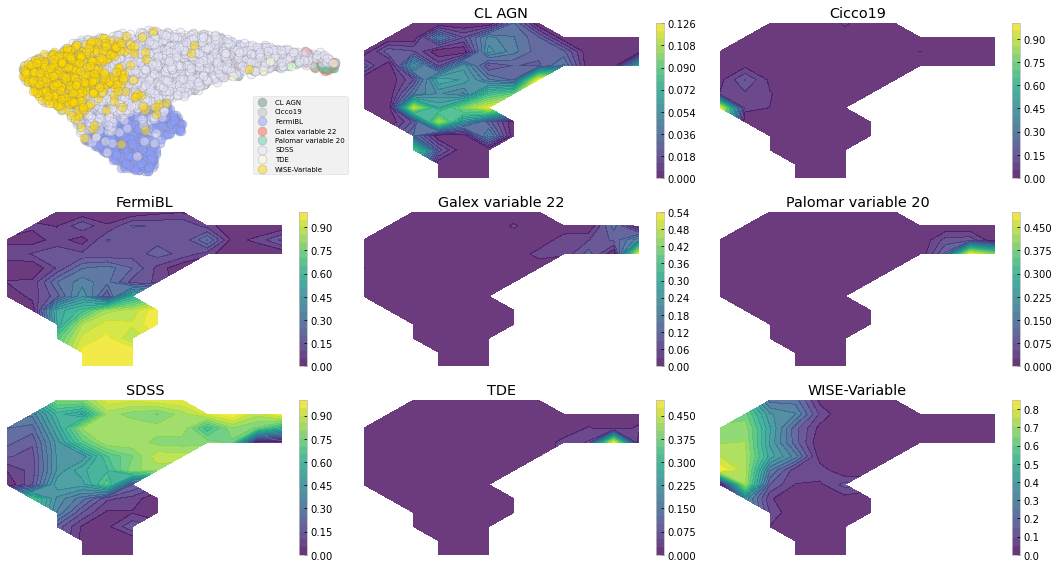

In [20]:
# Calculate 2D histogram
hist, x_edges, y_edges = np.histogram2d(mapper.embedding_[:, 0], mapper.embedding_[:, 1], bins=12)

# Calculate class probabilities for each bin
class_probabilities = []

for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    hist_per_cluster, _, _ = np.histogram2d(mapper.embedding_[u,0], mapper.embedding_[u,1], bins=(x_edges, y_edges))
    class_prob = hist_per_cluster / hist
    class_probabilities.append(class_prob)
    #print(lab, class_prob)

labs = np.unique(fzr)
plt.figure(figsize=(15,8))
ax0 = plt.subplot(3,3,1)
for i, prob in enumerate(class_probabilities):
    plt.subplot(3,3,i+2)
    plt.title(labs[i])
    plt.contourf(x_edges[:-1], y_edges[:-1], prob.T, levels=20, alpha=0.8)
    plt.colorbar()
    plt.axis('off')
    u=(fzr[:]==labs[i])
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=80,c=colors[i],alpha=0.5,edgecolor='gray',label=labs[i])
ax0.legend(loc=4,fontsize=7)
ax0.axis('off')
plt.tight_layout()


# Wise alone

  0%|          | 0/5199 [00:00<?, ?it/s]

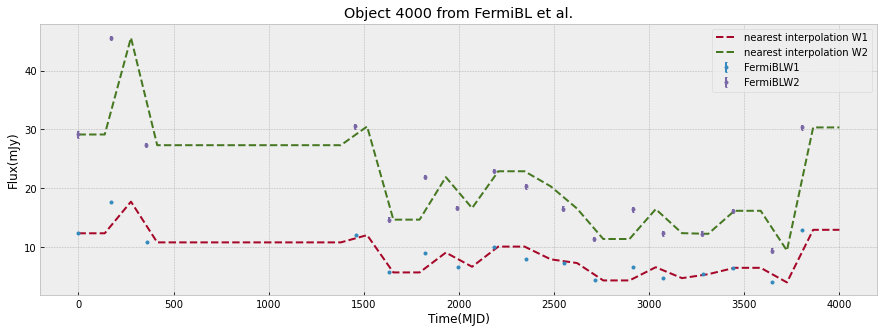

 47%|████▋     | 2437/5199 [00:19<00:22, 124.44it/s]

In [ ]:
bands_inlc = ['W1','W2']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=30)
# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)
dat_notnormal = combine_bands(objects,bands_inlc)
dat = normalize_clipmax_objects(dat_notnormal,maxarray,band = -1)
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

In [ ]:
plt.figure(figsize=(18,6))
markersize=200
mapper = umap.UMAP(n_neighbors=200,min_dist=1,metric='manhattan',random_state=5).fit(data)

ax1 = plt.subplot(1,3,2)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=np.log10(np.nansum(meanarray,axis=0)),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(1,3,3)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.nansum(fvar_arr[-2:-1,:],axis=0),factor=4),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(1,3,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')

plt.tight_layout()
#plt.savefig('umap-wise.png')

In [ ]:
# Calculate 2D histogram
hist, x_edges, y_edges = np.histogram2d(mapper.embedding_[:, 0], mapper.embedding_[:, 1], bins=12)

# Calculate class probabilities for each bin
class_probabilities = []

for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    hist_per_cluster, _, _ = np.histogram2d(mapper.embedding_[u,0], mapper.embedding_[u,1], bins=(x_edges, y_edges))
    class_prob = hist_per_cluster / hist
    class_probabilities.append(class_prob)
    #print(lab, class_prob)

labs = np.unique(fzr)
plt.figure(figsize=(15,8))
ax0 = plt.subplot(3,3,1)
for i, prob in enumerate(class_probabilities):
    plt.subplot(3,3,i+2)
    plt.title(labs[i])
    plt.contourf(x_edges[:-1], y_edges[:-1], prob.T, levels=20, alpha=0.8)
    plt.colorbar()
    plt.axis('off')
    u=(fzr[:]==labs[i])
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=80,c=colors[i],alpha=0.5,edgecolor='gray',label=labs[i])
ax0.legend(loc=4,fontsize=7)
ax0.axis('off')
plt.tight_layout()
#plt.savefig('wise.png')

In [ ]:
plt.figure(figsize=(16,12))
markersize=200

mapper = umap.UMAP(n_neighbors=5,min_dist=0.01,metric='euclidean',random_state=20).fit(data)
ax0 = plt.subplot(2,2,1)
ax0.set_title(r'Euclidean Distance, min_d=0.01, n_neighbors=5',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')

mapper = umap.UMAP(n_neighbors=50,min_dist=0.5,metric='manhattan',random_state=20).fit(data)
ax0 = plt.subplot(2,2,2)
ax0.set_title(r'Manhattan Distance, min_d=0.5, n_neighbors=50',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')


mapperg = umap.UMAP(n_neighbors=50,min_dist=0.5,metric=dtw_distance,random_state=20).fit(data) #this distance takes long
ax2 = plt.subplot(2,2,3)
ax2.set_title(r'DTW Distance, min_d=0.5,n_neighbors=50',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')


mapper = umap.UMAP(n_neighbors=7,min_dist=0.1,metric='manhattan',random_state=20).fit(data)
ax0 = plt.subplot(2,2,4)
ax0.set_title(r'Manhattan Distance, min_d=0.1, n_neighbors=7',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')
